Connect to Drive


---



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/HW1

/gdrive/My Drive/HW1


# **Libraries** 

In [3]:
import tensorflow as tf

import os
import time 

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

# Download and import splitfolders library
!pip install split-folders
import splitfolders

# Download and import visualkeras library
!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

     |████████████████████████████████| 795 kB 5.1 MB/s 
2.7.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load the **Dataset**

In [5]:
# Load the dataset to be used for classification
if not os.path.exists('data'):
  !unzip data.zip
if not os.path.exists('dataset'):
  splitfolders.ratio('data/', output='dataset', seed=seed, ratio=(.8, .2),)

Streaming output truncated to the last 5000 lines.
  inflating: data/Tomato/37979.jpg   
  inflating: data/Tomato/37980.jpg   
  inflating: data/Tomato/37982.jpg   
  inflating: data/Tomato/37983.jpg   
  inflating: data/Tomato/37984.jpg   
  inflating: data/Tomato/37985.jpg   
  inflating: data/Tomato/37988.jpg   
  inflating: data/Tomato/37989.jpg   
  inflating: data/Tomato/37990.jpg   
  inflating: data/Tomato/37992.jpg   
  inflating: data/Tomato/37993.jpg   
  inflating: data/Tomato/37994.jpg   
  inflating: data/Tomato/37995.jpg   
  inflating: data/Tomato/37996.jpg   
  inflating: data/Tomato/37997.jpg   
  inflating: data/Tomato/37998.jpg   
  inflating: data/Tomato/37999.jpg   
  inflating: data/Tomato/38000.jpg   
  inflating: data/Tomato/38001.jpg   
  inflating: data/Tomato/38003.jpg   
  inflating: data/Tomato/38004.jpg   
  inflating: data/Tomato/38005.jpg   
  inflating: data/Tomato/38006.jpg   
  inflating: data/Tomato/38007.jpg   
  inflating: data/Tomato/38008.jpg   

Copying files: 17728 files [03:55, 75.41 files/s]


In [6]:
# Dataset folders 

dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

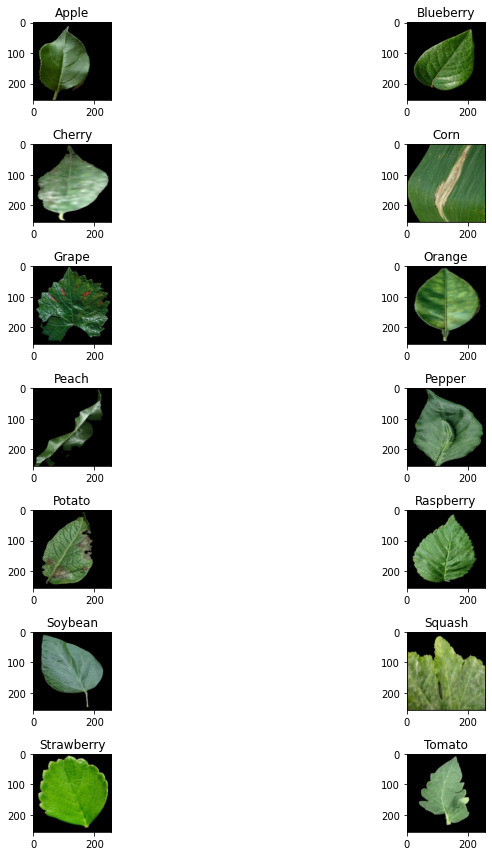

In [7]:
#optional
# Plot example images from dataset
 
labels = ['Apple',              # 0
          'Blueberry',          # 1
          'Cherry',             # 2
          'Corn',               # 3
          'Grape',              # 4
          'Orange',             # 5
          'Peach',              # 6
          'Pepper',             # 7
          'Potato',             # 8
          'Raspberry',          # 9
          'Soybean',            # 10
          'Squash',             # 11
          'Strawberry',         # 12
          'Tomato']             # 13     


num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 14:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [8]:
# Inspect dataset structure on disk
print("Depth 0 (dataset)")
print("-------")
!ls dataset
print()
print("Depth 1 (e.g., dataset/train)")
print("------------------------")
!ls dataset/train
print()
print("Depth 2 (e.g., dataset/training/Apple)")
print("------------------------")
!ls dataset/train/Apple

Depth 0 (dataset)
-------
train  val

Depth 1 (e.g., dataset/train)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., dataset/training/Apple)
------------------------
00001.jpg  00183.jpg  00360.jpg  00533.jpg  22479.jpg  22658.jpg  22845.jpg
00003.jpg  00184.jpg  00361.jpg  00534.jpg  22480.jpg  22660.jpg  22847.jpg
00004.jpg  00185.jpg  00362.jpg  00535.jpg  22482.jpg  22664.jpg  22848.jpg
00006.jpg  00187.jpg  00363.jpg  00536.jpg  22483.jpg  22667.jpg  22849.jpg
00007.jpg  00188.jpg  00364.jpg  00537.jpg  22484.jpg  22671.jpg  22850.jpg
00009.jpg  00189.jpg  00365.jpg  00538.jpg  22487.jpg  22673.jpg  22851.jpg
00011.jpg  00192.jpg  00366.jpg  00539.jpg  22488.jpg  22676.jpg  22853.jpg
00012.jpg  00193.jpg  00367.jpg  00543.jpg  22490.jpg  22677.jpg  22854.jpg
00013.jpg  00194.jpg  00372.jpg  00544.jpg  22492.jpg  22679.jpg  22855.jpg
00015.jpg  00196.jpg  00374.jpg 

# **Data Loader and Data Augmentation**

In [9]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='reflect',
                                    preprocessing_function=preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=True,
                                              seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 14176 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [10]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_gen.classes),
                                        y = train_gen.classes                                                
                                    )
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))

In [11]:
input_shape = (256, 256, 3)

#**CNN model**  

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

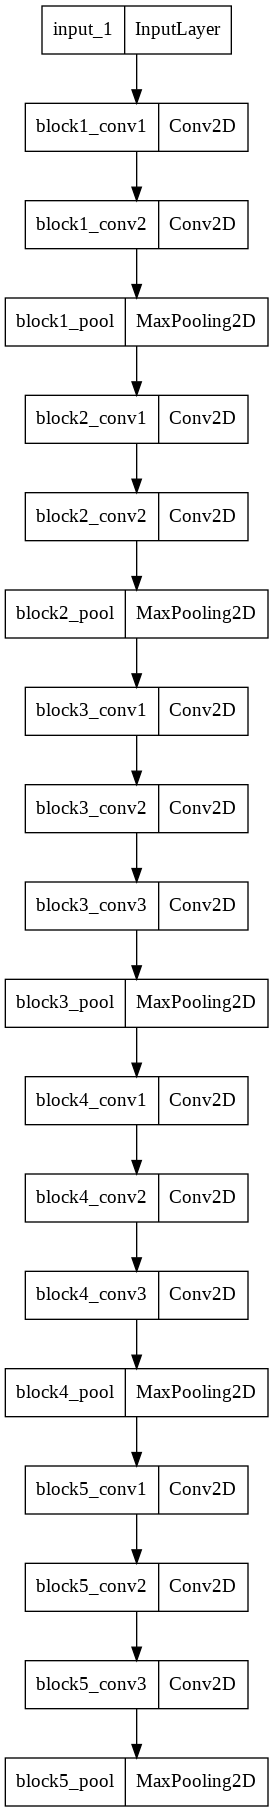

In [12]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [13]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    supernet.trainable = False

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Resizing(256, 256, interpolation="bicubic")(input_layer)
    x = supernet(x)


    flattening_layer = tfkl.Flatten(name='Flatten')(x)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=256, name='Classifier1', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='categorical_accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 Classifier1 (Dense)         (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

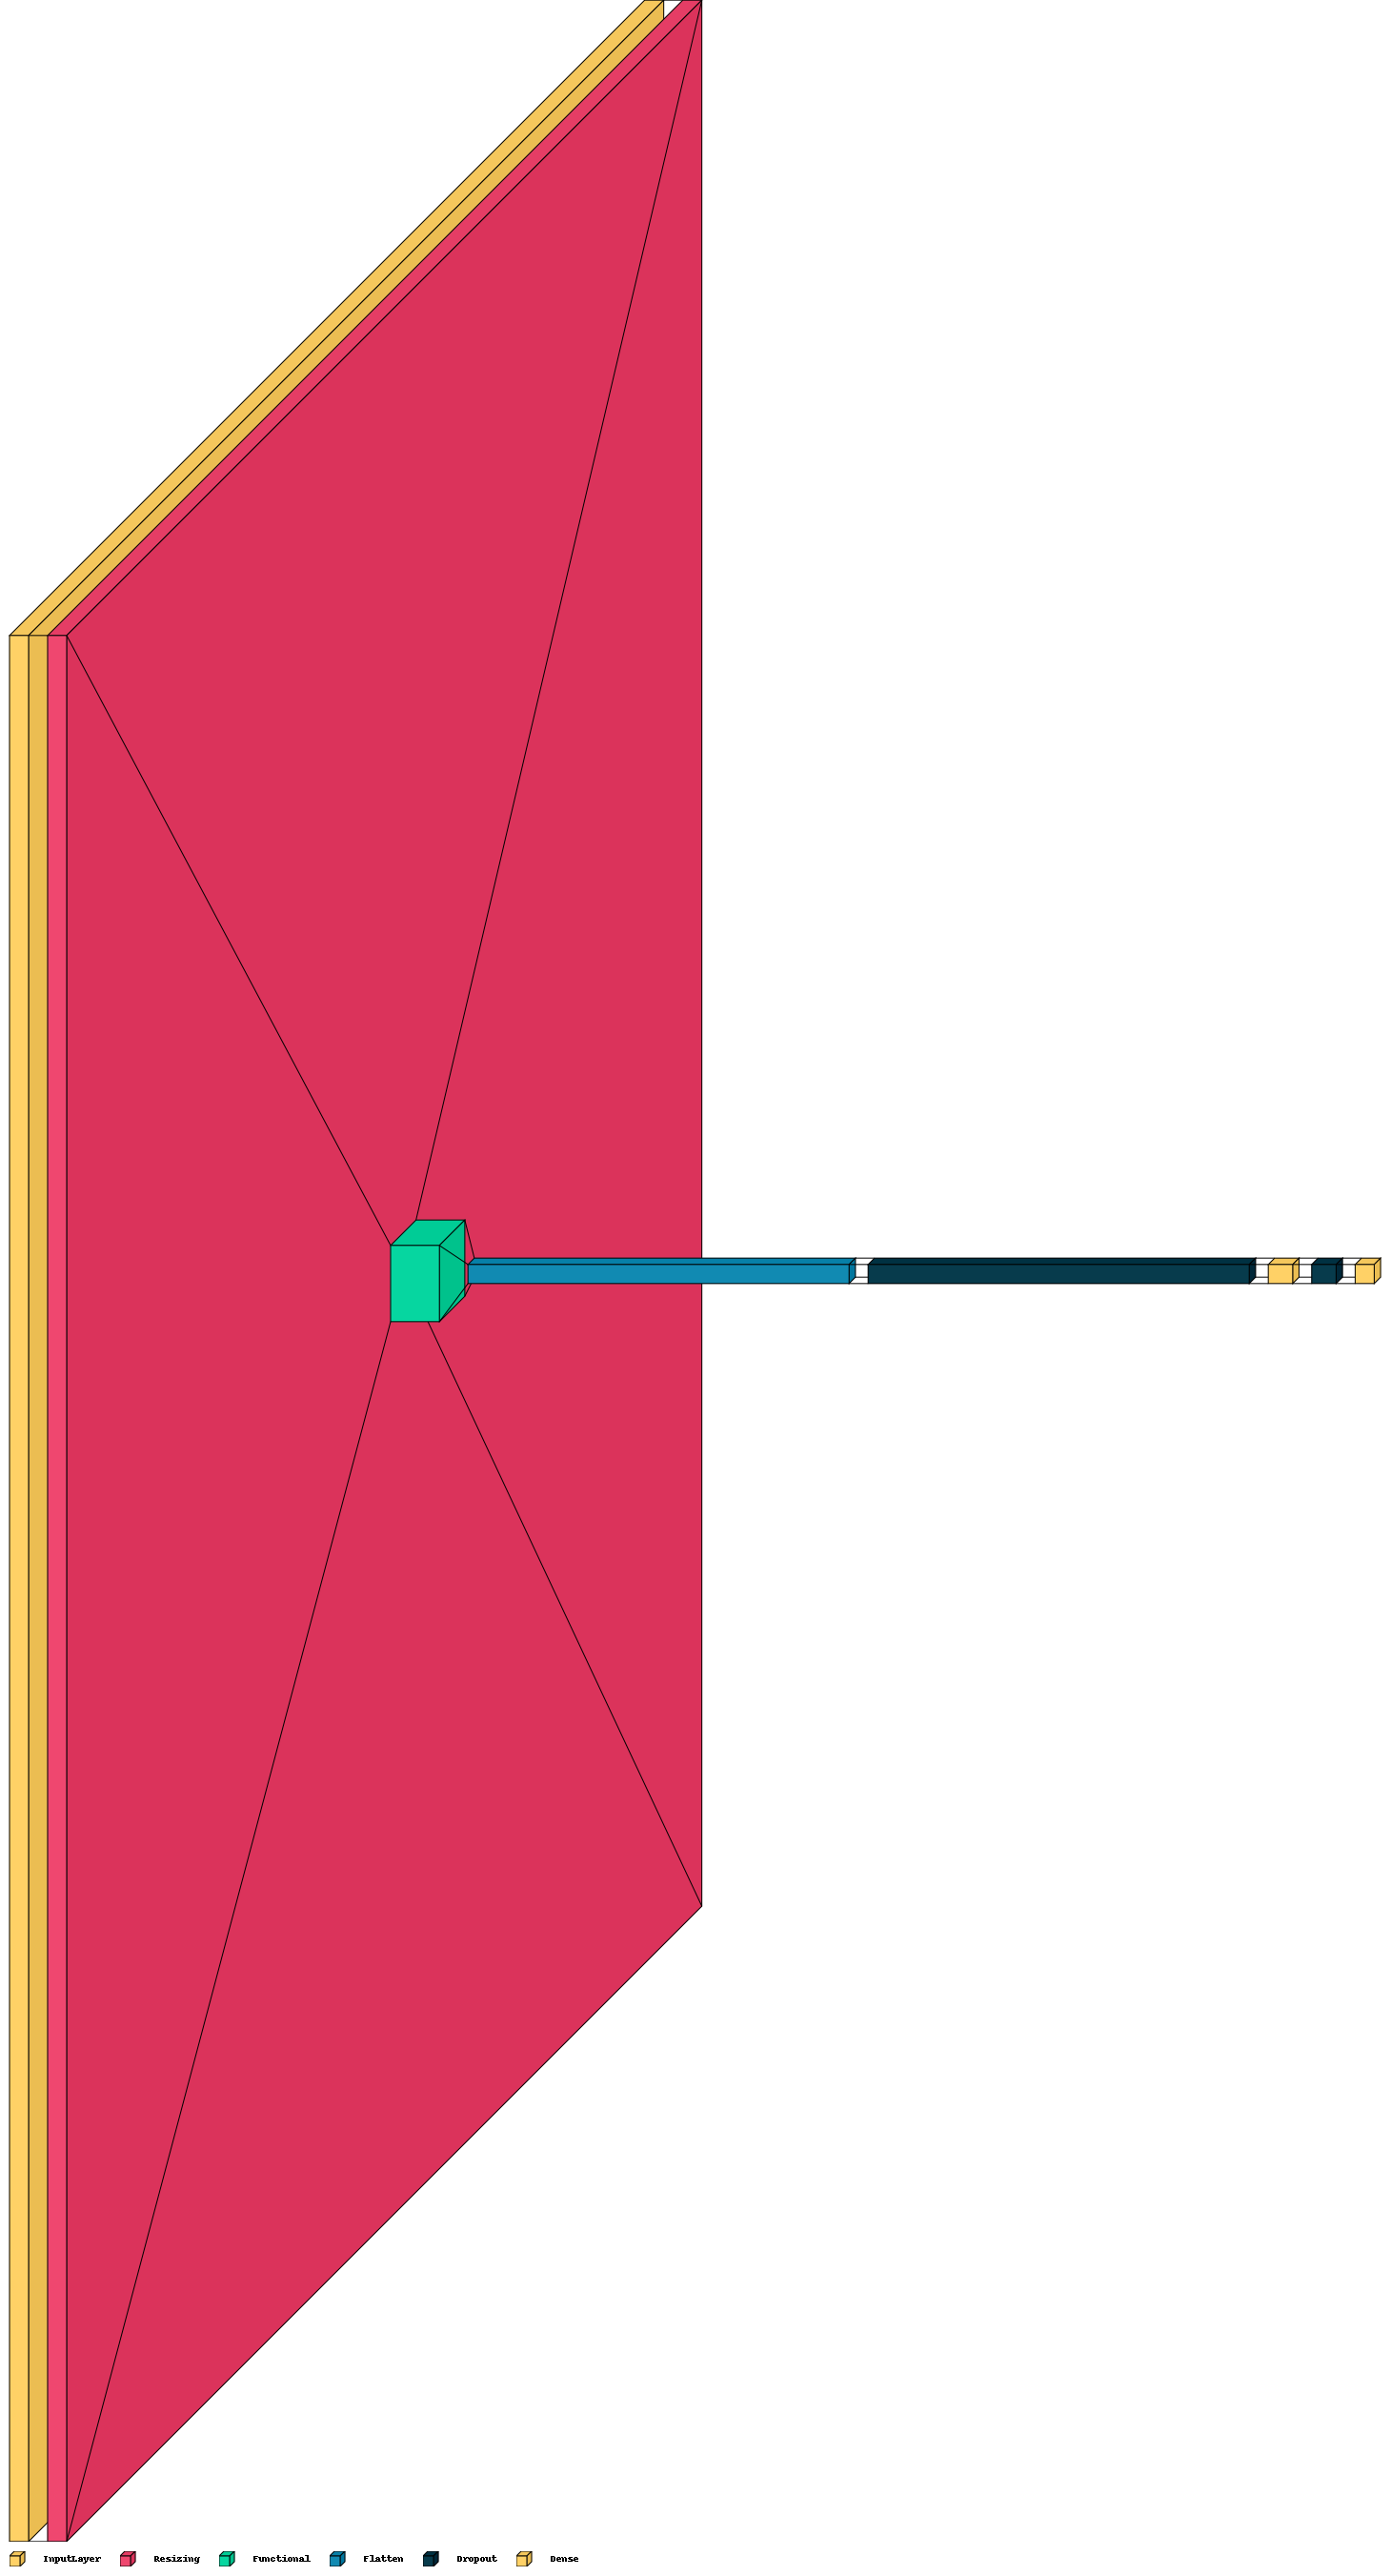

In [14]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [15]:
# Set all VGG layers to True
model.get_layer('vgg16').trainable = True
for i, layer in enumerate(model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [16]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 32768)             0        

In [17]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='categorical_accuracy')

# **Train Model**


In [18]:
# Utility callbacks for training

callbacks = []

# Model checkpoint
# ----------------

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath='Submission/SubmissionModel/ckpt/hw1-FineTuning-02',
                                                   monitor='categorical_accuracy', save_weights_only=False, save_best_only=True) 
callbacks.append(ckpt_callback)

# Early Stopping
# --------------
es_callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=10, restore_best_weights=True)
callbacks.append(es_callback)

In [19]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = 20,
    batch_size = 256,
    validation_data = valid_gen,
    callbacks = callbacks,
    class_weight = class_weights
).history

Epoch 1/20
1772/1772 [==============================] - ETA: 0s - loss: 2.0225 - categorical_accuracy: 0.3232

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 434s 238ms/step - loss: 2.0225 - categorical_accuracy: 0.3232 - val_loss: 1.2169 - val_categorical_accuracy: 0.6363
Epoch 2/20
1772/1772 [==============================] - ETA: 0s - loss: 1.2112 - categorical_accuracy: 0.5595

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 419s 236ms/step - loss: 1.2112 - categorical_accuracy: 0.5595 - val_loss: 0.5156 - val_categorical_accuracy: 0.8471
Epoch 3/20
1772/1772 [==============================] - ETA: 0s - loss: 0.6422 - categorical_accuracy: 0.7781

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 421s 238ms/step - loss: 0.6422 - categorical_accuracy: 0.7781 - val_loss: 0.2727 - val_categorical_accuracy: 0.9198
Epoch 4/20
1772/1772 [==============================] - ETA: 0s - loss: 0.4581 - categorical_accuracy: 0.8336

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 414s 234ms/step - loss: 0.4581 - categorical_accuracy: 0.8336 - val_loss: 0.1847 - val_categorical_accuracy: 0.9581
Epoch 5/20
1772/1772 [==============================] - ETA: 0s - loss: 0.3256 - categorical_accuracy: 0.8992

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 418s 236ms/step - loss: 0.3256 - categorical_accuracy: 0.8992 - val_loss: 0.1596 - val_categorical_accuracy: 0.9566
Epoch 6/20
1772/1772 [==============================] - ETA: 0s - loss: 0.2709 - categorical_accuracy: 0.9189

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 420s 237ms/step - loss: 0.2709 - categorical_accuracy: 0.9189 - val_loss: 0.2659 - val_categorical_accuracy: 0.9350
Epoch 7/20
1772/1772 [==============================] - ETA: 0s - loss: 0.2892 - categorical_accuracy: 0.9235

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 420s 237ms/step - loss: 0.2892 - categorical_accuracy: 0.9235 - val_loss: 0.1201 - val_categorical_accuracy: 0.9679
Epoch 8/20
1772/1772 [==============================] - ETA: 0s - loss: 0.2173 - categorical_accuracy: 0.9288

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 420s 237ms/step - loss: 0.2173 - categorical_accuracy: 0.9288 - val_loss: 0.1406 - val_categorical_accuracy: 0.9671
Epoch 9/20
1772/1772 [==============================] - ETA: 0s - loss: 0.2566 - categorical_accuracy: 0.9389

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 418s 236ms/step - loss: 0.2566 - categorical_accuracy: 0.9389 - val_loss: 1.9430 - val_categorical_accuracy: 0.8820
Epoch 10/20
1772/1772 [==============================] - 412s 232ms/step - loss: 0.2522 - categorical_accuracy: 0.9343 - val_loss: 0.1760 - val_categorical_accuracy: 0.9530
Epoch 11/20
1772/1772 [==============================] - 415s 234ms/step - loss: 0.2617 - categorical_accuracy: 0.9310 - val_loss: 0.1963 - val_categorical_accuracy: 0.9465
Epoch 12/20
1772/1772 [==============================] - 415s 234ms/step - loss: 0.2514 - categorical_accuracy: 0.9294 - val_loss: 0.2114 - val_categorical_accuracy: 0.9637
Epoch 13/20
1772/1772 [==============================] - ETA: 0s - loss: 0.1977 - categorical_accuracy: 0.9455

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 416s 235ms/step - loss: 0.1977 - categorical_accuracy: 0.9455 - val_loss: 0.2293 - val_categorical_accuracy: 0.9510
Epoch 14/20
1772/1772 [==============================] - 414s 234ms/step - loss: 0.2242 - categorical_accuracy: 0.9391 - val_loss: 0.1192 - val_categorical_accuracy: 0.9640
Epoch 15/20
1772/1772 [==============================] - ETA: 0s - loss: 0.2164 - categorical_accuracy: 0.9471

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-FineTuning-02/assets


1772/1772 [==============================] - 420s 237ms/step - loss: 0.2164 - categorical_accuracy: 0.9471 - val_loss: 1.8332 - val_categorical_accuracy: 0.8052
Epoch 16/20
1772/1772 [==============================] - 411s 232ms/step - loss: 0.2150 - categorical_accuracy: 0.9469 - val_loss: 0.2016 - val_categorical_accuracy: 0.9730
Epoch 17/20
1772/1772 [==============================] - 412s 232ms/step - loss: 0.2075 - categorical_accuracy: 0.9369 - val_loss: 0.1467 - val_categorical_accuracy: 0.9752
Epoch 18/20
1772/1772 [==============================] - 408s 230ms/step - loss: 0.2756 - categorical_accuracy: 0.9381 - val_loss: 1.0334 - val_categorical_accuracy: 0.9417
Epoch 19/20
1772/1772 [==============================] - 408s 230ms/step - loss: 0.2416 - categorical_accuracy: 0.9428 - val_loss: 0.2183 - val_categorical_accuracy: 0.9792
Epoch 20/20
1772/1772 [==============================] - 405s 228ms/step - loss: 0.4526 - categorical_accuracy: 0.9371 - val_loss: 0.1012 - val_cat

In [20]:
model.save('Submission/SubmissionModel/hw1-FineTuning-02')

INFO:tensorflow:Assets written to: Submission/SubmissionModel/hw1-FineTuning-02/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/hw1-FineTuning-02/assets


In [ ]:
model = tfk.models.load_model('Submission/SubmissionModel/ckpt/hw1-FineTuning-02')

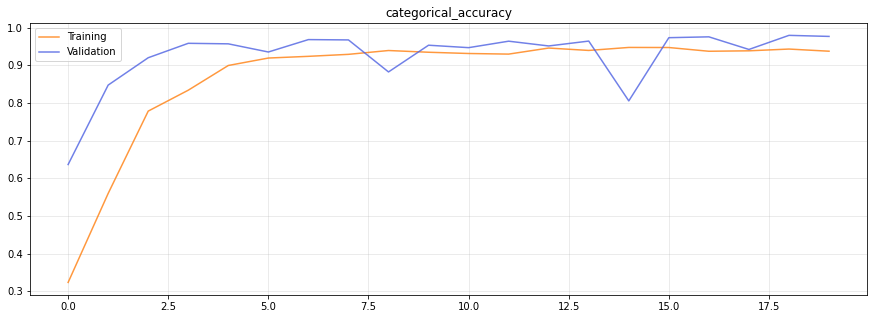

In [26]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['categorical_accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_categorical_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('categorical_accuracy')
plt.grid(alpha=.3)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Accuracy: 0.9764
Precision: 0.9672
Recall: 0.9869
F1: 0.976


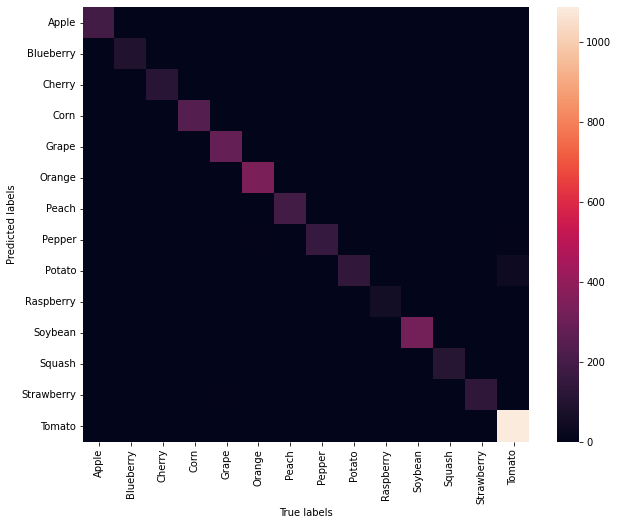

Classification Report
              precision    recall  f1-score   support

       Apple       0.97      0.98      0.98       198
   Blueberry       0.98      1.00      0.99        94
      Cherry       0.98      0.99      0.99       117
        Corn       1.00      1.00      1.00       242
       Grape       0.99      0.97      0.98       292
      Orange       0.99      0.97      0.98       350
       Peach       0.99      0.99      0.99       196
      Pepper       0.92      1.00      0.96       153
      Potato       0.79      0.99      0.88       144
   Raspberry       0.98      1.00      0.99        53
     Soybean       0.99      0.99      0.99       324
      Squash       1.00      0.97      0.99       115
  Strawberry       0.95      1.00      0.97       135
      Tomato       0.99      0.95      0.97      1139

    accuracy                           0.98      3552
   macro avg       0.97      0.99      0.98      3552
weighted avg       0.98      0.98      0.98      3552



In [25]:
# Compute the confusion matrix
predictions = model.predict_generator(generator=valid_gen)
predictions = np.argmax(predictions, axis=1)


cm = confusion_matrix(valid_gen.classes, predictions)
# Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, predictions)
precision = precision_score(valid_gen.classes, predictions, average='macro')
recall = recall_score(valid_gen.classes, predictions, average='macro')
f1 = f1_score(valid_gen.classes, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


#Print Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)
print(classification_report(valid_gen.classes, predictions, target_names=target_names))